In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('max_colwidth',-1)

In [61]:
deliveries = pd.read_csv('IPL Ball-by-Ball Dataset 2021.csv')
df = deliveries.copy()
df.head(2)

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,1254058,1,0,1,RG Sharma,CA Lynn,Mohammed Siraj,2,0,2,0,0,NaN,NaN,NaN,NaN,Mumbai Indians,Royal Challengers Bangalore
1,1254058,1,0,2,RG Sharma,CA Lynn,Mohammed Siraj,0,0,0,0,0,NaN,NaN,NaN,NaN,Mumbai Indians,Royal Challengers Bangalore


# Data Cleaning

In [63]:
# Firstly we will do some data cleaning
# here we are considering only one team:CSK 

In [64]:
df.batting_team.unique()

array(['Mumbai Indians', 'Royal Challengers Bangalore',
       'Chennai Super Kings', 'Delhi Capitals', 'Kolkata Knight Riders',
       'Sunrisers Hyderabad', 'Punjab Kings', 'Rajasthan Royals'],
      dtype=object)

In [65]:
df_batsman = df[df.batting_team == 'Chennai Super Kings']
df_batsman.head(2)

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
250,1254059,1,0,1,RD Gaikwad,F du Plessis,CR Woakes,0,0,0,0,0,NaN,NaN,NaN,NaN,Chennai Super Kings,Delhi Capitals
251,1254059,1,0,2,RD Gaikwad,F du Plessis,CR Woakes,0,0,0,0,0,NaN,NaN,NaN,NaN,Chennai Super Kings,Delhi Capitals


In [66]:
df_bowler = df[df.bowling_team == 'Chennai Super Kings']
df_bowler.head(2)

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
373,1254059,2,0,1,PP Shaw,S Dhawan,DL Chahar,0,0,0,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Chennai Super Kings
374,1254059,2,0,2,PP Shaw,S Dhawan,DL Chahar,4,0,4,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Chennai Super Kings


In [67]:
# Now we will get phase wise data for batsmen and bowlers seperately 
# Before this we should introduce one column named Phase to each datasets

In [68]:
def getPhase(over):
    if over < 6:
        return 'Powerplay'
    elif over < 16:
        return 'Middle'
    else:
        return 'Death'

In [69]:
df_batsman['Phase'] = df_batsman['over'].apply(lambda x:getPhase(x))

In [70]:
df_batsman.head(1)

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team,Phase
250,1254059,1,0,1,RD Gaikwad,F du Plessis,CR Woakes,0,0,0,0,0,NaN,NaN,NaN,NaN,Chennai Super Kings,Delhi Capitals,Powerplay


In [71]:
df_bowler['Phase'] = df_bowler['over'].apply(lambda x:getPhase(x))
df_bowler.head(1)

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team,Phase
373,1254059,2,0,1,PP Shaw,S Dhawan,DL Chahar,0,0,0,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Chennai Super Kings,Powerplay


In [72]:
def balls_per_dismissals(balls,dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1
    
def balls_per_boundaries(balls,boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1

In [73]:
def getPhaseBatsman(df, current_phase):
    df = df[df.Phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x:1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x : 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x : 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x : 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x : 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x : 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum()).reset_index().rename(columns = {'batsman_runs':'runs'})
    balls = pd.DataFrame(df.groupby(['batsman'])['id'].count()).reset_index().rename(columns = {'id':'balls'})
    innings = pd.DataFrame(df.groupby(['batsman'])['id'].apply(lambda x : len(list(np.unique(x))))).reset_index().rename(columns={'id':'innings'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns={'player_dismissed':'dismissals'})
    four = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns={'isFour':'Four'})
    six = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns={'isSix':'Six'})
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns={'isDot':'dots'})
    
    df = pd.merge(innings, runs, on='batsman').merge(balls, on='batsman').merge(dismissals, on='batsman').merge(four, on='batsman').merge(six, on='batsman').merge(dots, on='batsman')
    
    
    df['rpi'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)
    df['SR'] = df.apply(lambda x: 100*x['runs']/x['balls'], axis = 1)
    df['bpd'] = df.apply(lambda x: balls_per_dismissals(x['balls'],x['dismissals']), axis = 1)  #balls per dismissals: no of balls for each dismissal
    df['bpb'] = df.apply(lambda x: balls_per_boundaries(x['balls'],(x['Four']+x['Six'])), axis = 1)  #balls per boundaries
    df['dot_percentage'] = df.apply(lambda x: (x['dots']/x['balls']), axis = 1)
    
    return df

In [74]:
batsman_powerplay = getPhaseBatsman(df_batsman,'Powerplay')

In [75]:
batsman_powerplay.head()

,batsman,innings,runs,balls,dismissals,Four,Six,dots,rpi,SR,bpd,bpb,dot_percentage
0,F du Plessis,5,104,72,2,11,5,29,20.800000,144.444444,36.0,4.500000,0.402778
1,MM Ali,3,22,24,0,4,0,14,7.333333,91.666667,24.0,6.000000,0.583333
2,RD Gaikwad,5,65,75,3,9,1,42,13.000000,86.666667,25.0,7.500000,0.560000
3,SK Raina,1,14,13,0,3,0,8,14.000000,107.692308,13.0,4.333333,0.615385


In [76]:
batsman_middle = getPhaseBatsman(df_batsman,'Middle')
batsman_middle.head()

,batsman,innings,runs,balls,dismissals,Four,Six,dots,rpi,SR,bpd,bpb,dot_percentage
0,AT Rayudu,4,62,40,3,2,6,16,15.500000,155.000000,13.333333,5.000000,0.400000
1,F du Plessis,3,82,72,1,8,1,24,27.333333,113.888889,72.000000,8.000000,0.333333
2,MM Ali,4,101,64,3,9,6,27,25.250000,157.812500,21.333333,4.266667,0.421875
3,MS Dhoni,2,6,13,1,0,0,9,3.000000,46.153846,13.000000,13.000000,0.692308
4,RA Jadeja,3,25,18,1,4,0,5,8.333333,138.888889,18.000000,4.500000,0.277778


In [77]:
batsman_death = getPhaseBatsman(df_batsman,'Death')
batsman_death.head()

,batsman,innings,runs,balls,dismissals,Four,Six,dots,rpi,SR,bpd,bpb,dot_percentage
0,AT Rayudu,1,2,3,1,0,0,1,2.000000,66.666667,3.0,3.000000,0.333333
1,DJ Bravo,1,20,10,1,2,1,4,20.000000,200.000000,10.0,3.333333,0.400000
2,F du Plessis,1,28,14,0,3,2,5,28.000000,200.000000,14.0,2.800000,0.357143
3,MM Ali,1,10,3,1,1,1,1,10.000000,333.333333,3.0,1.500000,0.333333
4,MS Dhoni,3,31,19,2,4,1,7,10.333333,163.157895,9.5,3.800000,0.368421


In [78]:
def is_bowlers_wicket(player_dismissed, dismissal_kind):
    if type(player_dismissed) == str:
        if dismissal_kind not in ['run_out','retired_hurt','obstructing the field']:
            return 1
        else:
            return 0
    else:
        return 0

In [79]:
df_bowler['isBowlerWK'] = df_bowler.apply(lambda x: is_bowlers_wicket(x['player_dismissed'],x['dismissal_kind']), axis = 1)

In [80]:
def balls_per_dismissals(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1
    
def runs_per_ball(runs, balls):     #economy rate
    if balls > 0:
        return runs/balls
    else:
        return runs/1
    
def runs_per_dismissal(runs, dismissals):
    if dismissals > 0:
        return runs/dismissals
    elif runs == 0:
        return runs/1
    else:
        return runs/1

In [81]:
def bowlerStats(df, current_phase):
    df = df[df.Phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    runs = pd.DataFrame(df.groupby(['bowler'])['total_runs'].sum()).reset_index().rename(columns = {'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['id'].apply(lambda x: len(list(np.unique(x))))).reset_index().rename(columns = {'id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['id'].count()).reset_index().rename(columns = {'id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWK'].sum()).reset_index().rename(columns = {'isBowlerWK':'dismissals'})
    
    df['isDot'] = df['total_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, balls, on='bowler').merge(runs, on='bowler').merge(dismissals, on='bowler').merge(dots, on='bowler')

    df['dot%'] = df.apply(lambda x: 100*x['dots']/x['balls'], axis = 1)
    df['SR'] = df.apply(lambda x: balls_per_dismissals(x['balls'],x['dismissals']),axis=1)
    df['ECO'] = df.apply(lambda x: 6*runs_per_ball(x['runs'],x['balls']),axis=1)
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'],x['dismissals']),axis=1)
    
    return df

In [82]:
bowler_powerplay = bowlerStats(df_bowler,'Powerplay')
bowler_powerplay.head()

,bowler,innings,balls,runs,dismissals,dots,dot%,SR,ECO,Avg
0,DL Chahar,5,88,112,8,40,45.454545,11.000000,7.636364,14.000000
1,L Ngidi,1,13,19,1,7,53.846154,13.000000,8.769231,19.000000
2,SM Curran,5,68,82,3,33,48.529412,22.666667,7.235294,27.333333
3,SN Thakur,3,18,33,1,6,33.333333,18.000000,11.000000,33.000000


In [83]:
bowler_middle = bowlerStats(df_bowler,'Middle')
bowler_middle.head()

,bowler,innings,balls,runs,dismissals,dots,dot%,SR,ECO,Avg
0,DJ Bravo,3,42,40,2,15,35.714286,21.000000,5.714286,20.000000
1,DL Chahar,3,18,25,1,9,50.000000,18.000000,8.333333,25.000000
2,Imran Tahir,1,26,16,3,14,53.846154,8.666667,3.692308,5.333333
3,L Ngidi,1,6,8,1,3,50.000000,6.000000,8.000000,8.000000
4,MM Ali,3,49,54,4,16,32.653061,12.250000,6.612245,13.500000


In [84]:
bowler_death = bowlerStats(df_bowler,'Death')
bowler_death.head()

,bowler,innings,balls,runs,dismissals,dots,dot%,SR,ECO,Avg
0,DJ Bravo,4,30,46,2,9,30.000000,15.00,9.200000,23.00
1,L Ngidi,1,6,5,1,4,66.666667,6.00,5.000000,5.00
2,MM Ali,1,6,4,0,2,33.333333,6.00,4.000000,4.00
3,SM Curran,4,25,32,2,9,36.000000,12.50,7.680000,16.00
4,SN Thakur,5,49,53,4,23,46.938776,12.25,6.489796,13.25


# Analyzing Batsmen

In [85]:
# Now we use MCDM method, for which we use following pairwise matrix 


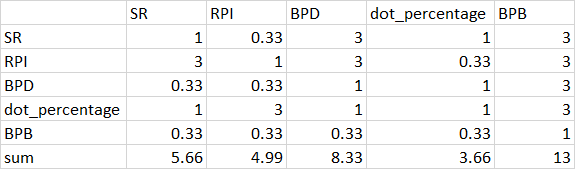

In [86]:
# Pairwise normalized matrix with weights is given as follows 


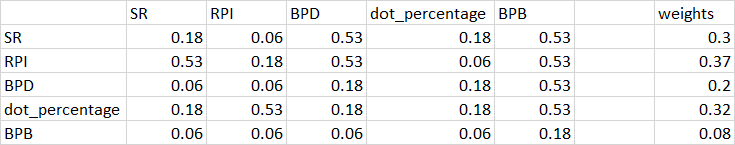

In [87]:
wt_SR, wt_RPI, wt_BPD, wt_dot_percentage, wt_BPB = 0.3,0.37,0.2,0.32,0.08

# TOPSIS method

In [123]:
def TopsisMethodBatsmen(df):
    df = df[df.innings > 1]
    # step 1: Calculate normalized matrix and then weighted normalized matrix
    # calculating squares of each column
    df['calc_RPI'] = df['rpi'].apply(lambda x: x*x)
    df['calc_SR'] = df['SR'].apply(lambda x: x*x)
    df['calc_BPD'] = df['bpd'].apply(lambda x: x*x)
    df['calc_BPB'] = df['bpb'].apply(lambda x: x*x)
    df['calc_dot_percentage'] = df['dot_percentage'].apply(lambda x: x*x)
    
    sq_rpi, sq_sr, sq_bpd, sq_bpb, sq_dot_percentage = np.sqrt(df[['calc_RPI','calc_SR','calc_BPD','calc_BPB','calc_dot_percentage']]).sum(axis=0)
    
    # calculating normalized matrix
    df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x/sq_rpi)
    df['calc_SR'] = df['calc_SR'].apply(lambda x: x/sq_sr)
    df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x/sq_bpd)
    df['calc_BPB'] = df['calc_BPB'].apply(lambda x: x/sq_bpb)
    df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x/sq_dot_percentage)
    
    # calculating weighted normalized matrix by multiplying by weights to each value in column
    df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x*wt_RPI)
    df['calc_SR'] = df['calc_SR'].apply(lambda x: x*wt_SR)
    df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x*wt_BPD)
    df['calc_BPB'] = df['calc_BPB'].apply(lambda x: x*wt_BPB)
    df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x*wt_dot_percentage)
    
    # calculating best and worst value columnwise which is max and min value respectively
    best_SR, worst_SR = max(df['calc_SR']), min(df['calc_SR'])
    best_RPI, worst_RPI = max(df['calc_RPI']), min(df['calc_RPI'])
    best_BPD, worst_BPD = max(df['calc_BPD']), min(df['calc_BPD'])
    best_BPB, worst_BPB = max(df['calc_BPB']), min(df['calc_BPB'])
    best_dot_percentage, worst_dot_percentage = max(df['calc_dot_percentage']), min(df['calc_dot_percentage'])
    
    # step 2: To calculate ideal best and ideal worst 
    df['best_SR1'] = df['calc_SR'].apply(lambda x: (x-best_SR)*(x-best_SR))
    df['best_RPI1'] = df['calc_RPI'].apply(lambda x: (x-best_RPI)*(x-best_RPI))
    df['best_BPD1'] = df['calc_BPD'].apply(lambda x: (x-best_BPD)*(x-best_BPD))
    df['best_BPB1'] = df['calc_BPB'].apply(lambda x: (x-best_BPB)*(x-best_BPB))
    df['best_dot_percentage1'] = df['calc_dot_percentage'].apply(lambda x: (x-best_dot_percentage)*(x-best_dot_percentage))
    
    df['best_sqrt'] = df.apply(lambda x: x['best_SR1']+x['best_RPI1']+x['best_BPD1']+x['best_BPB1']+x['best_dot_percentage1'], axis = 1)
    
    df['worst_SR1'] = df['calc_SR'].apply(lambda x: (x-worst_SR)*(x-worst_SR))
    df['worst_RPI1'] = df['calc_RPI'].apply(lambda x: (x-worst_RPI)*(x-worst_RPI))
    df['worst_BPD1'] = df['calc_BPD'].apply(lambda x: (x-worst_BPD)*(x-worst_BPD))
    df['worst_BPB1'] = df['calc_BPB'].apply(lambda x: (x-worst_BPB)*(x-worst_BPB))
    df['worst_dot_percentage1'] = df['calc_dot_percentage'].apply(lambda x: (x-worst_dot_percentage)*(x-worst_dot_percentage))
    
    df['worst_sqrt'] = df.apply(lambda x: x['worst_SR1']+x['worst_RPI1']+x['worst_BPD1']+x['worst_BPB1']+x['worst_dot_percentage1'], axis = 1)
    
    # step 3: Find TOPSIS score        
    df['score'] = df.apply(lambda x: x['worst_sqrt']/(x['worst_sqrt']+x['best_sqrt']), axis = 1)
    
    return df


In [124]:
batsman_powerplay_final = TopsisMethodBatsmen(batsman_powerplay)
batsman_powerplay_final = batsman_powerplay_final.sort_values(by = 'score', ascending = False).reset_index()
batsman_powerplay_final[['batsman','innings','runs','balls','SR','score']].head()

,batsman,innings,runs,balls,SR,score
0,F du Plessis,5,104,72,144.444444,0.999840
1,RD Gaikwad,5,65,75,86.666667,0.006824
2,MM Ali,3,22,24,91.666667,0.004641


In [125]:
batsman_middle_final = TopsisMethodBatsmen(batsman_middle)
batsman_middle_final = batsman_middle_final.sort_values(by = 'score', ascending = False).reset_index()
batsman_middle_final[['batsman','innings','runs','balls','SR','score']].head()

,batsman,innings,runs,balls,SR,score
0,F du Plessis,3,82,72,113.888889,0.717948
1,RD Gaikwad,2,52,31,167.741935,0.652991
2,MM Ali,4,101,64,157.812500,0.607724
3,SM Curran,2,10,6,166.666667,0.584488
4,AT Rayudu,4,62,40,155.000000,0.527063


In [126]:
batsman_death_final = TopsisMethodBatsmen(batsman_death)
batsman_death_final = batsman_death_final.sort_values(by = 'score', ascending = False).reset_index()
batsman_death_final[['batsman','innings','runs','balls','SR','score']].head()

,batsman,innings,runs,balls,SR,score
0,RA Jadeja,4,77,36,213.888889,0.997743
1,SM Curran,2,42,20,210.000000,0.816411
2,MS Dhoni,3,31,19,163.157895,0.000019


# Analyzing Bowlers

In [128]:
# Pairwise and normalized pairwise matrix for bowler's parameters is given as follows:

	
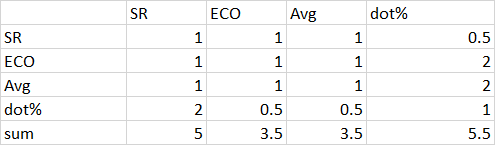

	
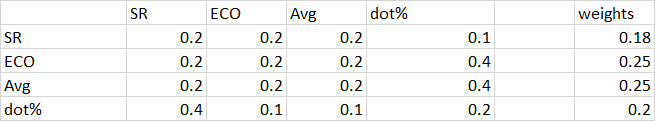

In [129]:
wt_sr, wt_eco, wt_avg, wt_dot = 0.18, 0.25, 0.25, 0.2

In [134]:
def TopsisMethodBowler(df):
    df = df[df.innings > 1]
    
    # step 1: Calculate normalized matrix and then weighted normalized matrix
    # calculating squares of each column
    df['calc_SR'] = df['SR'].apply(lambda x: x*x)
    df['calc_ECO'] = df['ECO'].apply(lambda x: x*x)
    df['calc_AVG'] = df['Avg'].apply(lambda x: x*x)
    df['calc_dot%'] = df['dot%'].apply(lambda x: x*x)
    
    sq_SR, sq_ECO, sq_AVG, sq_dot = np.sqrt(df[['calc_SR','calc_ECO','calc_AVG','calc_dot%']]).sum(axis = 0)
    
    # calculating normalized matrix
    df['calc_SR'] = df['calc_SR'].apply(lambda x: x/sq_SR)
    df['calc_ECO'] = df['calc_ECO'].apply(lambda x: x/sq_ECO)
    df['calc_AVG'] = df['calc_AVG'].apply(lambda x: x/sq_AVG)
    df['calc_dot%'] = df['calc_dot%'].apply(lambda x: x/sq_dot)
    
    # calculating weighted normalized matrix by multiplying by weights to each value in column
    df['calc_SR'] = df['calc_SR'].apply(lambda x: x*wt_sr)
    df['calc_ECO'] = df['calc_ECO'].apply(lambda x: x*wt_eco)
    df['calc_AVG'] = df['calc_AVG'].apply(lambda x: x*wt_avg)
    df['calc_dot%'] = df['calc_dot%'].apply(lambda x: x*wt_dot)
    
    # calculating best and worst value columnwise which is max and min value respectively
    best_SR, worst_SR = max(df['calc_SR']), min(df['calc_SR'])
    best_ECO, worst_ECO = max(df['calc_ECO']), min(df['calc_ECO'])
    best_AVG, worst_AVG = max(df['calc_AVG']), min(df['calc_AVG'])
    best_dot, worst_dot = max(df['calc_dot%']), min(df['calc_dot%'])
    
    # step 2: To calculate ideal best and ideal worst
    df['best_SR1'] = df['calc_SR'].apply(lambda x: (x-best_SR)*(x-best_SR))
    df['best_ECO1'] = df['calc_ECO'].apply(lambda x: (x-best_ECO)*(x-best_ECO))
    df['best_AVG1'] = df['calc_AVG'].apply(lambda x: (x-best_AVG)*(x-best_AVG))
    df['best_dot%1'] = df['calc_dot%'].apply(lambda x: (x-best_dot)*(x-best_dot))
    
    df['best_sqrt'] = df.apply(lambda x: x['best_SR1']+x['best_ECO1']+x['best_AVG1']+x['best_dot%1'], axis = 1)
    
    df['worst_SR1'] = df['calc_SR'].apply(lambda x: (x-worst_SR)*(x-worst_SR))
    df['worst_ECO1'] = df['calc_ECO'].apply(lambda x: (x-worst_ECO)*(x-worst_ECO))
    df['worst_AVG1'] = df['calc_AVG'].apply(lambda x: (x-worst_AVG)*(x-worst_AVG))
    df['worst_dot%1'] = df['calc_dot%'].apply(lambda x: (x-worst_dot)*(x-worst_dot))
    
    df['worst_sqrt'] = df.apply(lambda x: x['worst_SR1']+x['worst_ECO1']+x['worst_AVG1']+x['worst_dot%1'], axis = 1)
    
    # step 3: Find TOPSIS score 
    df['score'] = df.apply(lambda x: x['worst_sqrt']/(x['worst_sqrt']+x['best_sqrt']), axis = 1)
    
    return df

In [135]:
bowler_powerplay_final = TopsisMethodBowler(bowler_powerplay)
bowler_powerplay_final = bowler_powerplay_final.sort_values(by = 'score', ascending = False).reset_index()
bowler_powerplay_final[['bowler','innings','balls','runs','dismissals','score']].head()

,bowler,innings,balls,runs,dismissals,score
0,SM Curran,5,68,82,3,0.838164
1,SN Thakur,3,18,33,1,0.700634
2,DL Chahar,5,88,112,8,0.164284


In [136]:
bowler_middle_final = TopsisMethodBowler(bowler_middle)
bowler_middle_final = bowler_middle_final.sort_values(by = 'score', ascending = False).reset_index()
bowler_middle_final[['bowler','innings','balls','runs','dismissals','score']].head()

,bowler,innings,balls,runs,dismissals,score
0,SN Thakur,5,50,83,0,0.976574
1,DL Chahar,3,18,25,1,0.032261
2,RA Jadeja,5,111,109,5,0.012405
3,DJ Bravo,3,42,40,2,0.004056
4,MM Ali,3,49,54,4,0.000302


In [137]:
bowler_death_final = TopsisMethodBowler(bowler_death)
bowler_death_final = bowler_death_final.sort_values(by = 'score', ascending = False).reset_index()
bowler_death_final[['bowler','innings','balls','runs','dismissals','score']].head()

,bowler,innings,balls,runs,dismissals,score
0,SN Thakur,5,49,53,4,0.626024
1,DJ Bravo,4,30,46,2,0.373976
2,SM Curran,4,25,32,2,0.131159


In [149]:
bowler_death_final.set_index(keys = 'bowler', inplace = True)
batsman_powerplay_final.set_index(keys = 'batsman', inplace = True)
batsman_middle_final.set_index(keys = 'batsman', inplace = True)
batsman_death_final.set_index(keys = 'batsman', inplace = True)
bowler_powerplay_final.set_index(keys = 'bowler', inplace = True)
bowler_middle_final.set_index(keys = 'bowler', inplace = True)

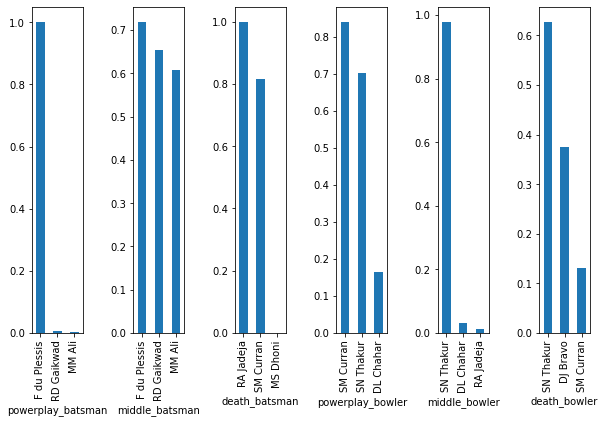

In [167]:

fig, axes = plt.subplots(nrows = 1, ncols = 6)

plot1 = batsman_powerplay_final['score'].head(3).plot(kind = 'bar', ax = axes[0],figsize = (10,6))
plot2 = batsman_middle_final['score'].head(3).plot(kind = 'bar', ax = axes[1])
plot3 = batsman_death_final['score'].head(3).plot(kind = 'bar', ax = axes[2])
plot4 = bowler_powerplay_final['score'].head(3).plot(kind = 'bar', ax = axes[3])
plot5 = bowler_middle_final['score'].head(3).plot(kind = 'bar', ax = axes[4])
plot6 = bowler_death_final['score'].head(3).plot(kind = 'bar', ax = axes[5])

plot1.set_xlabel('powerplay_batsman')
plot2.set_xlabel('middle_batsman')
plot3.set_xlabel('death_batsman')
plot4.set_xlabel('powerplay_bowler')
plot5.set_xlabel('middle_bowler')
plot6.set_xlabel('death_bowler')

plt.subplots_adjust(wspace = 1)
plt.savefig('CSK Phasewise.png')
plt.show()